In [146]:
import sqlite3
import pandas as pd
from datetime import datetime, timedelta

%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [2]:
# Setup sqlite
sqlite_file = 'hyper_live_thursday.db'
connection = sqlite3.connect(sqlite_file)
db = connection.cursor()

In [3]:
# read ALL tweets from db
all_tweets = pd.read_sql_query("SELECT * FROM TweetsRaw", connection)
all_tweets['createdAt'] = pd.to_datetime(all_tweets['createdAt'], format ='%a %b %d %H:%M:%S +0000 %Y')
all_tweets.index = all_tweets['createdAt']
print("{} tweets in db".format(len(all_tweets)))

9617 tweets in db


In [112]:
# Construct a dataframe joining data from TweetsRaw and BandTweets
band_tweets = pd.read_sql_query("SELECT bt.bandId, \
                                        b.name AS bandName, \
                                        b.codedName AS bandCodedName, \
                                        b.headLevel AS headLevel, \
                                        b.popularity AS popularity, \
                                        tr.* \
                                 FROM BandTweets AS bt\
                                 LEFT JOIN TweetsRaw AS tr ON bt.tweetRawId == tr.id \
                                 LEFT JOIN Bands AS b ON bt.bandId == b.id", connection)
band_tweets['createdAt'] = pd.to_datetime(band_tweets['createdAt'], format ='%a %b %d %H:%M:%S +0000 %Y')
band_tweets['createdAt'] = band_tweets['createdAt'] + timedelta(hours=2)
band_tweets.index = band_tweets['createdAt']
print("{} band tweets in db".format(band_tweets.shape[0]))

3932 band tweets in db


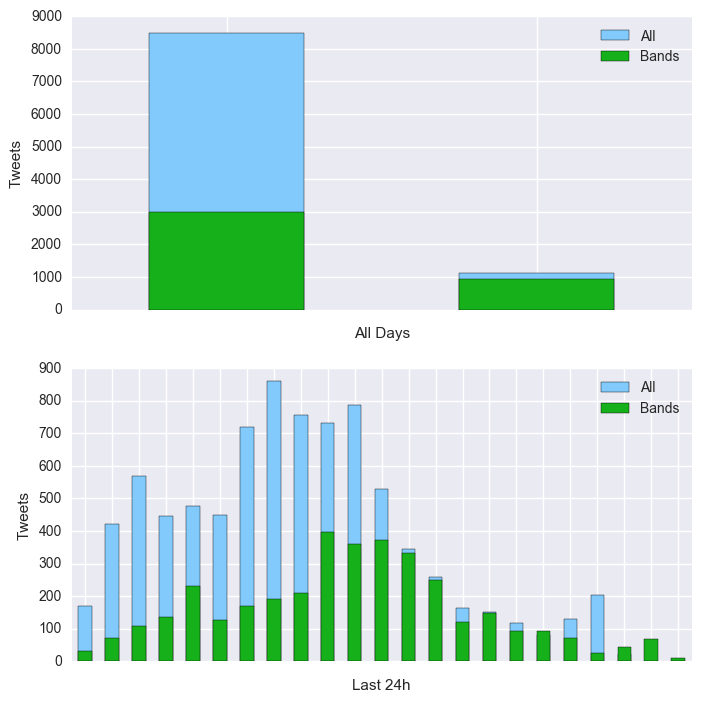

In [113]:
# https://chrisalbon.com/python/pandas_group_data_by_time.html

# timeline plot comparing alltweets vs bandtweets
fig = plt.figure(figsize=(8, 6))
plt.subplots_adjust(top=1.2)
ax1 = fig.add_subplot(211)
all_tweets.resample('D').count()['tweetId'].plot(kind='bar', \
                                                 color=sns.xkcd_rgb['sky'], \
                                                 label='All', \
                                                 ax=ax1)
band_tweets.resample('D').count()['bandId'].plot(kind='bar', \
                                                 color=sns.xkcd_rgb['green'], \
                                                 label='Bands', \
                                                 ax=ax1)
ax1.set_xlabel("All Days")
ax1.set_xticklabels([])
#ax1.set_xticklabels(list(np.arange(min(all_tweets['createdAt']).day, max(all_tweets['createdAt']).day + 1)), rotation=None)
ax1.set_ylabel("Tweets")
ax1.legend()


# get recent tweets (last 24h)
recent_all_tweets = all_tweets[ all_tweets['createdAt'] > (datetime.now() - timedelta(hours=24))]
recent_band_tweets = band_tweets[ band_tweets['createdAt'] > (datetime.now() - timedelta(hours=24))]

# plot last day of tweets & band_tweets
ax2 = fig.add_subplot(212)
ax2 = recent_all_tweets.resample('H').count()['tweetId'].plot(kind='bar', \
                                                              color=sns.xkcd_rgb['sky'], \
                                                              label='All', \
                                                              ax=ax2)
recent_band_tweets.resample('H').count()['bandId'].plot(kind='bar', \
                                                        color=sns.xkcd_rgb['green'], \
                                                        label='Bands', \
                                                        ax=ax2)
ax2.set_xlabel("Last 24h")
ax2.set_xticklabels([])
ax2.set_ylabel("Tweets")
ax2.legend()

In [115]:
# get most mentioned bands
#band_tweets[['bandId','bandCodedName', 'processed']].groupby(['bandId', 'bandCodedName']).count().sort_values(by='processed', ascending=False)

[None]

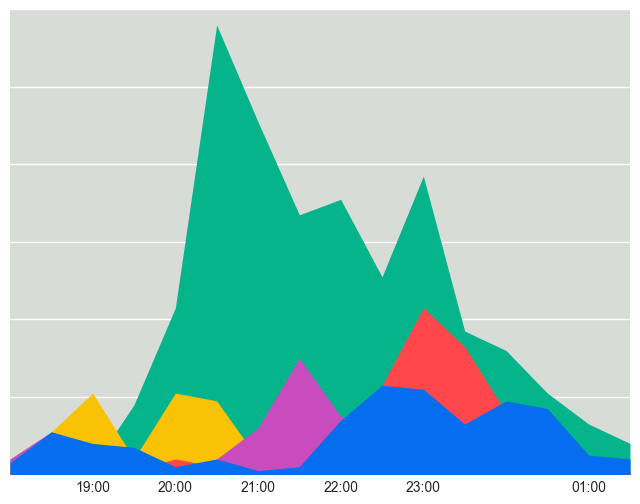

In [152]:
# Timeline of n bands between start and end times

# set band to filter
bands = [
            {'codedName':'arcadefire', 'name':'Arcade Fire', 'color':'green blue'},
            {'codedName':'mishima', 'name':'Mishima', 'color':'goldenrod'},
            {'codedName':'theafghanwhigs', 'name':'The Afghan Whigs', 'color':'light red'},
            {'codedName':'solange', 'name':'Solange', 'color':'pinky purple'},
            {'codedName':'boniver', 'name':'Bon Iver', 'color':'cerulean blue'}
        ];

# set start-end times in UTC
start = '2017-06-1 18:00'
end   = '2017-06-2 02:00'
start_datetime = datetime.strptime(start, '%Y-%m-%d %H:%M')
end_datetime = datetime.strptime(end, '%Y-%m-%d %H:%M')

# create figrue
fig = plt.figure(figsize=(8, 6))
ax3 = fig.add_subplot(111)

palette = itertools.cycle(sns.color_palette("hls", 5))

for band in bands:

    # filter by band
    single_band_tweets = band_tweets[band_tweets['bandCodedName'] == band['codedName']]

    # create a datetime version of the createdAt column and filter by start and end
    single_band_tweets = single_band_tweets[single_band_tweets['createdAt'] > start_datetime]
    single_band_tweets = single_band_tweets[single_band_tweets['createdAt'] < end_datetime]

    # plot tweets
    ax3 = single_band_tweets.resample('30T').count()['tweetId'].plot(kind='area', \
                                                                     color=sns.xkcd_rgb[band['color']], \
                                                                     linewidth=0, \
                                                                     linestyle='-', \
                                                                     label=band['name'], \
                                                                     ax=ax3)
        
    #sns.xkcd_rgb[band['color']], \
    # next(palette), \

#ax3.set_ylabel("Tweets / 30 minutes")
#ax3.set_yticks([])
ax3.set_yticklabels(['','','','','','','','','','',])

ax3.set_xlabel("")
ax3.set_xticks([])
ax3.set_xticklabels([])

ax3.set(axis_bgcolor=sns.xkcd_rgb['light grey'])

#ax3.legend()

# create a fake legend to have lines with width larger than 0
#import copy
#handles, labels = ax3.get_legend_handles_labels() # get the handles
#handles = [copy.copy(ha) for ha in handles] # copy the handles
#[ha.set_linewidth(5) for ha in handles] # set the linewidths to the copies
#plt.legend(handles=handles, labels=labels) # put the copies into the legend
#ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=5)

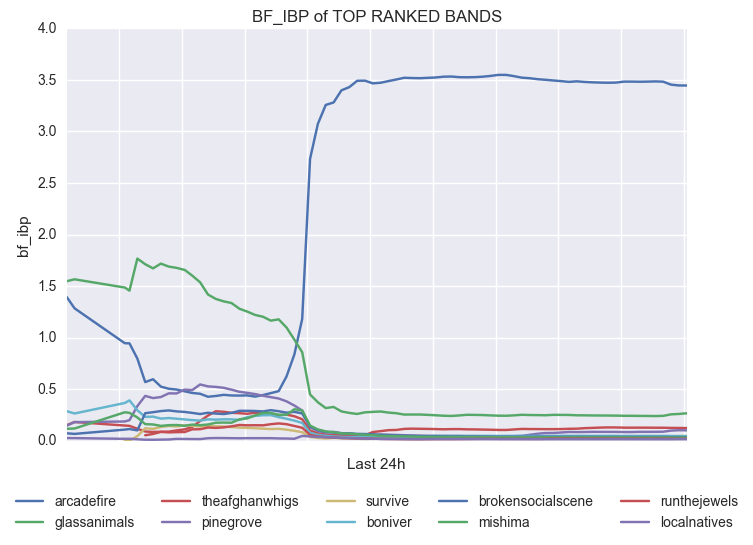

In [86]:
# BF_IBP of TOP RANKED BANDS

hours_plot = 24

# Read current ranking
current_ranking = pd.read_sql_query("""	SELECT b.codedName AS bandCodedName, cr.tweets, cr.favs, cr.retweets, cr.bf_ibp 
                                       	FROM BandsHype AS cr 
                                    	LEFT JOIN Bands AS b ON cr.bandId = b.id""", connection)

# Read history of rankings
rankings = pd.read_sql_query("""SELECT b.codedName AS bandCodedName, rs.tweets, rs.favs, rs.retweets, rs.bf_ibp, rs.createdAt 
                            	FROM BandsHypeHis AS rs
                            	LEFT JOIN Bands AS b ON rs.bandId = b.id""", connection)

# filter last N-hours
rankings['createdAt'] = pd.to_datetime(rankings['createdAt'], format ='%a %b %d %H:%M:%S +0000 %Y')
recent_rankings = rankings[ rankings['createdAt'] > (datetime.now() - timedelta(hours=hours_plot))]

# get top-10 bands
top_10 = current_ranking.sort_values('bf_ibp', ascending = False)['bandCodedName'][0:10]

# plot band evolution
bands = top_10
ax4 = plt.figure().add_subplot(111)
for b in bands:
	recent_rankings[recent_rankings['bandCodedName'] == b].set_index('createdAt').plot(y='bf_ibp', label=b, ax=ax4)
ax4.set_title('BF_IBP of TOP RANKED BANDS')
ax4.set_ylabel('bf_ibp')
ax4.set_xlabel('Last {}h'.format(hours_plot))
ax4.set_xticklabels([])
plt.gcf().subplots_adjust(bottom=0.15)
ax4.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=5)

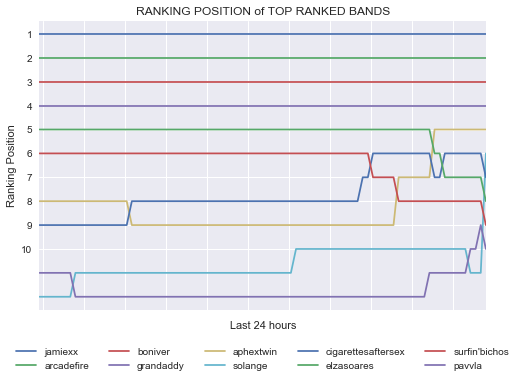

In [13]:
# RANKING POSITION of TOP RANKED BANDS

hours_plot = 24

# Read current ranking
current_ranking = pd.read_sql_query("""	SELECT b.codedName AS bandCodedName, cr.tweets, cr.favs, cr.retweets, cr.bf_ibp, cr.ranking_position
                                       	FROM BandsHype AS cr 
                                    	LEFT JOIN Bands AS b ON cr.bandId = b.id""", connection)

# Read history of rankings
rankings = pd.read_sql_query("""SELECT b.codedName AS bandCodedName, rs.tweets, rs.favs, rs.retweets, rs.bf_ibp, rs.createdAt, rs.ranking_position  
                            	FROM BandsHypeHis AS rs
                            	LEFT JOIN Bands AS b ON rs.bandId = b.id""", connection)

# filter last N-hours
rankings['createdAt'] = pd.to_datetime(rankings['createdAt'], format ='%a %b %d %H:%M:%S +0000 %Y')
recent_rankings = rankings[ rankings['createdAt'] > (datetime.now() - timedelta(hours=hours_plot))]

# get top-10 bands
top_10 = current_ranking.sort_values('ranking_position', ascending = True)['bandCodedName'][0:10]

# plot band evolution
bands = top_10
ax5 = plt.figure().add_subplot(111)
for b in bands:
	recent_rankings[recent_rankings['bandCodedName'] == b].set_index('createdAt').plot(y='ranking_position', label=b, ax=ax5)
ax5.set_title('RANKING POSITION of TOP RANKED BANDS')
ax5.set_ylabel('Ranking Position')
ax5.set_yticks([1,2,3,4,5,6,7,8,9,10])
ax5.set_xlabel('Last {} hours'.format(hours_plot))
ax5.set_xticklabels([])
plt.gcf().subplots_adjust(bottom=0.15)
ax5.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=5)
ax5.invert_yaxis()

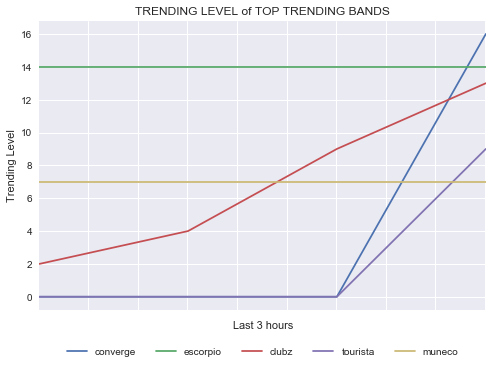

In [14]:
# TRENDING LEVEL of TOP TRENDING BANDS

hours_plot = 3

# Read current ranking
current_ranking = pd.read_sql_query("""	SELECT b.codedName AS bandCodedName, cr.tweets, cr.favs, cr.retweets, cr.bf_ibp, cr.trending_level
                                       	FROM BandsHype AS cr 
                                    	LEFT JOIN Bands AS b ON cr.bandId = b.id""", connection)

# Read history of rankings
rankings = pd.read_sql_query("""SELECT b.codedName AS bandCodedName, rs.tweets, rs.favs, rs.retweets, rs.bf_ibp, rs.createdAt, rs.trending_level  
                            	FROM BandsHypeHis AS rs
                            	LEFT JOIN Bands AS b ON rs.bandId = b.id""", connection)

# filter last N-hours
rankings['createdAt'] = pd.to_datetime(rankings['createdAt'], format ='%a %b %d %H:%M:%S +0000 %Y')
recent_rankings = rankings[rankings['createdAt'] > (datetime.now() - timedelta(hours=hours_plot))]

# get top-10 bands
top_10 = current_ranking.sort_values('trending_level', ascending = False)['bandCodedName'][0:5]

# plot band evolution
bands = top_10
ax6 = plt.figure().add_subplot(111)
for b in bands:
	recent_rankings[recent_rankings['bandCodedName'] == b].set_index('createdAt').plot(y='trending_level', label=b, ax=ax6)
ax6.set_title('TRENDING LEVEL of TOP TRENDING BANDS')
ax6.set_ylabel('Trending Level')
ax6.set_xlabel('Last {} hours'.format(hours_plot))
ax6.set_xticklabels([])
plt.gcf().subplots_adjust(bottom=0.15)
ax6.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=5)